# Imports

In [2]:
import numpy as np
from iminuit.cost import LeastSquares
from iminuit import Minuit
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex', 'grid']) #ieee, grid

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

from funcs import *
from stats import *
from Fit import *

# Functions

In [85]:
def H_R(w,tau, a):
    return w*tau/np.sqrt(1+np.power(w*tau,2)) + a

def H_C(w,tau, a):
    return 1/np.sqrt(1+np.power(w*tau,2)) + a

def fase_R(w,tau, a):
    return np.arctan(1/(w*tau)) + a

def fase_C(w,tau, a):
    return -np.arctan(w*tau) + a

# Presa Dati

In [5]:
if 1:
    path_folder = 'data.leo/RC/'
    V_res, V_c, fase_res, fase_c, freqs, V_res_err, V_c_err = [], [], [], [], [], [], []

    for i in sorted([int(i) for i in os.listdir(path_folder)]):

        path = path_folder+str(i)+'/'

        CH1,SGN,MTH, V_SGN, V_MTH, zero_CH1, zero_SGN, zero_MTH, m1, m2, m3, dt_CH1, dt_MTH, V_SGN_err, V_MTH_err = analize(path, i, force=True, prec=1e-8,verbose=True)
        
        # x=np.linspace(np.min(CH1[0]), np.max(CH1[0]), 100)

        # plt.figure(figsize=(10,4))
        # plt.plot(x, sine(x, **m1.values.to_dict()), label='CH1 fit', color='red')
        # plt.plot(x, sine(x, **m2.values.to_dict()), label='SGN fit', color='blue')
        # plt.plot(x, sine(x, **m3.values.to_dict()), label='MTH fit', color='green')
        
        # # plt.plot(CH1[0], CH1[1], label='CH1', color='red')
        # # plt.plot(SGN[0], SGN[1], label='SGN', color='blue')
        # # plt.plot(MTH[0], MTH[1], label='MTH', color='green')

        # plt.scatter(zero_CH1, 0, color='red', label='zero CH1')
        # plt.scatter(zero_SGN, 0, color='blue', label='zero SGN')
        # plt.scatter(zero_MTH, 0, color='green', label='zero MTH')
        # plt.legend(ncol=2)
        # plt.show()
        # print(i, dt_CH1, dt_MTH)

        V_res.append(V_SGN)
        V_c.append(V_MTH)
        V_res_err.append(V_SGN_err)
        V_c_err.append(V_MTH_err)
        fase_res.append(dt_CH1*i*2*np.pi)
        fase_c.append(dt_MTH*i*2*np.pi)
        freqs.append(i)

    V_res = np.array(V_res)
    V_c = np.array(V_c)
    V_res_err = np.array(V_res_err)
    V_c_err = np.array(V_c_err)
    fase_res = np.array(fase_res)
    fase_c = np.array(fase_c)
    freqs = np.array(freqs)

# Modulo $|H|$

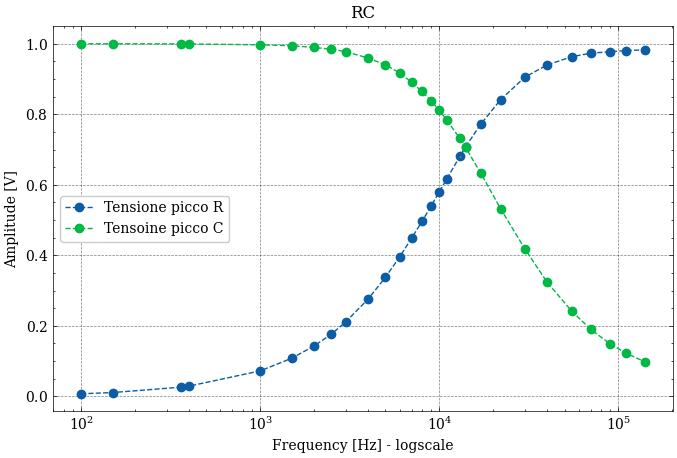

In [6]:
plt.figure(figsize=(8,5))
x = np.linspace(np.min(freqs),np.max(freqs),1000)

# plt.plot(x, H_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
# plt.plot(x, H_C(x*2*np.pi, 1e3*12e-9), label='Teorico')
plt.plot(freqs, V_res, 'o--', label='Tensione picco R')
plt.plot(freqs, V_c, 'o--', label='Tensoine picco C')
plt.errorbar(freqs, V_res, yerr=V_res_err,linestyle='None')
plt.errorbar(freqs, V_c, yerr=V_c_err, linestyle='None')
plt.title('RC')
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Amplitude [V]')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.show()

# Fase $\phi(H)$

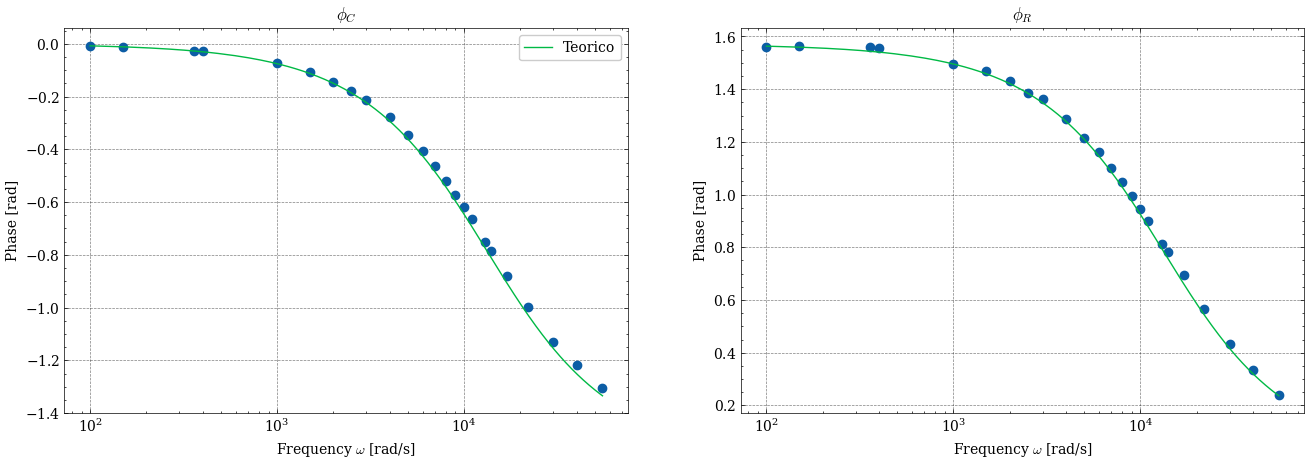

In [10]:
x = np.linspace(np.min(freqs[:-4]),np.max(freqs[:-4]),1000)

plt.subplots(1,2,figsize=(16,5))
plt.title('Dati')
plt.subplot(1,2,1)
plt.plot(freqs[:-4], -fase_c[:-4],'o', lw=1)
plt.plot(x, fase_C(x*2*np.pi, 1e3*12e-9, 0.), label='Teorico')
plt.title('$\phi_C$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.legend()
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(freqs[:-4], -fase_res[:-4] + np.pi*2, 'o', lw=1)
plt.plot(x, fase_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
plt.title('$\phi_R$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.xscale('log')

# plt.savefig('imgs/RC/fasi_no_log.jpeg', bbox_inches='tight', dpi=200)
plt.show()

# R

{'tau': 1.1459765765115353e-05, 'a': -0.002284566503751828}
{'tau': 2.5279918388635712e-08, 'a': 0.0005160188856671085}
C =  1.1494248510647295e-08


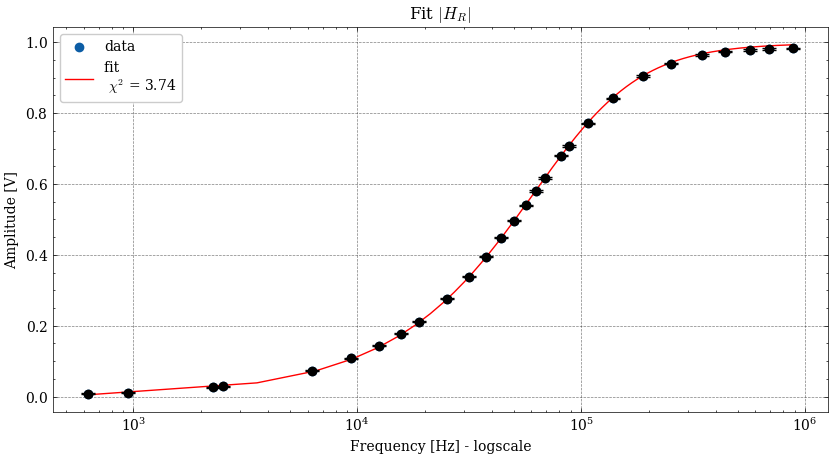

In [58]:
f_m = Fit(freqs*2*np.pi, V_res, H_R, V_res_err*200, kwargs={'tau':1e3*12e-9, 'a':0.})
f_m.fit()
fig, ax = f_m.visualize(cov=False)
fig.set_size_inches(10,5)
ax.set_xscale('log')
plt.legend()
plt.title('Fit $|H_R|$')
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Amplitude [V]')

print(f_m.values)
print(f_m.errors)
print("C = ",f_m.values['tau']/997)

{'tau': 1.1529415162337472e-05, 'a': 0.0008276911445930146}
{'tau': 7.0929418992583506e-09, 'a': 0.0002005434606457753}
R =  0.960784596861456
180.00600988803066


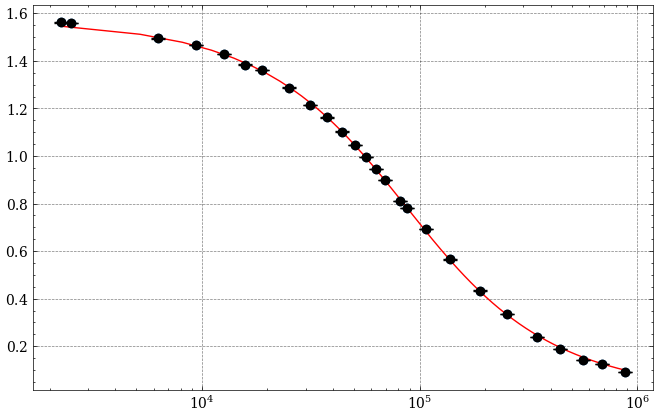

In [55]:
f_f = Fit(freqs[2:]*2*np.pi, -fase_res[2:]+ 2*np.pi, fase_R, 0.0005, kwargs={'tau':12e-9*1e3, 'a':0})
f_f.fit()
fig, ax = f_f.visualize()
fig.set_size_inches(8,5)
print(f.values)
print(f.errors)
print('R = ', f_f.values['tau']/12e-6)
print(f_f.fval/f_f.ndof)
plt.xscale('log')

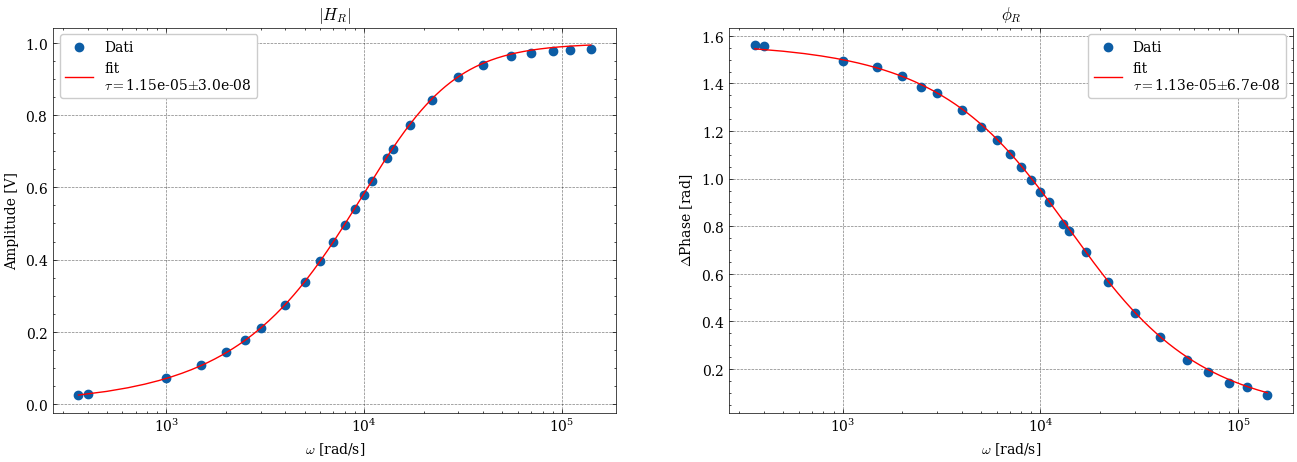

In [101]:
plt.subplots(1,2,figsize=(16,5))
x = np.linspace(np.min(freqs[2:]),np.max(freqs[2:]),1000)
plt.subplot(1,2,1)
plt.title("$|H_R|$")
plt.scatter(freqs[2:], V_res[2:], lw=1, label='Dati')
plt.plot(x, H_R(x*2*np.pi, f_m.values['tau'], f_m.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_m.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_m.errors["tau"])}', color='red')
plt.xscale('log')
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel('Amplitude [V]')
plt.legend()

plt.subplot(1,2,2)
plt.title("$\phi_R$")
plt.scatter(freqs[2:], -fase_res[2:]+(np.pi*2), lw=1, label='Dati')
plt.plot(x, fase_R(x*2*np.pi, f_f.values['tau'], f_f.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_f.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_f.errors["tau"])}', color='red')
plt.xscale('log')
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel('$\Delta$Phase [rad]')
plt.legend()

plt.savefig('imgs/RC/fit_R.pdf', bbox_inches='tight', dpi=200)

# C

{'tau': 1.1473956303199103e-05, 'a': -0.0009367008902023913}
C =  1.1508481748444436e-08


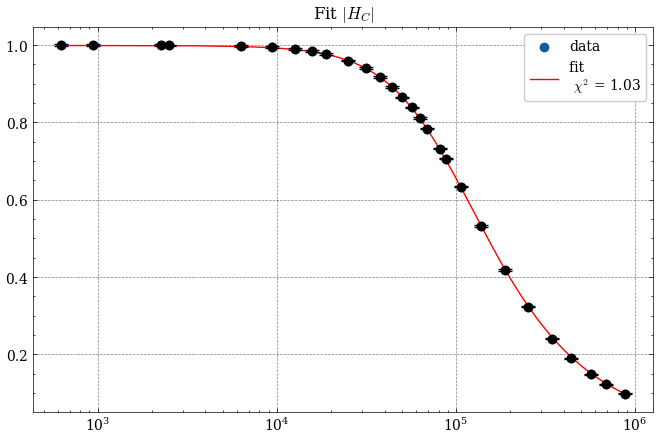

In [90]:
f_m = Fit(freqs*2*np.pi, V_c, H_C, V_c_err*200, kwargs={'tau':1e3*12e-9, 'a':0.})
f_m.fit()
fig, ax = f_m.visualize()
fig.set_size_inches(8,5)
plt.xscale('log')
plt.legend()
plt.title('Fit $|H_C|$')

print(f_m.values)
print("C = ",f_m.values['tau']/997)

{'tau': 1.133624252235072e-05, 'a': 0.0002875749593313036}
{'tau': 6.659156001341418e-08, 'a': 0.0019579745198703385}
1.089075649762001


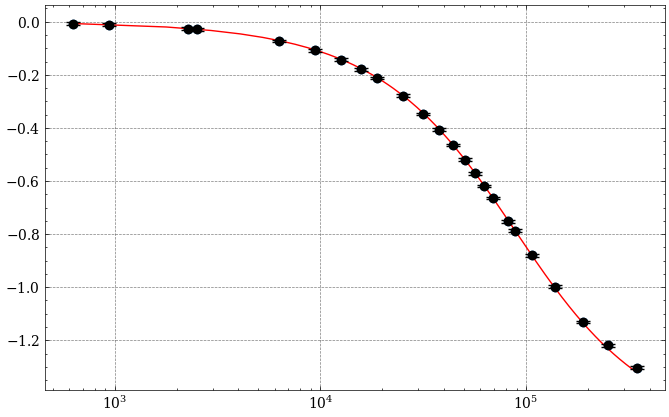

In [91]:
f_f = Fit(freqs[:-4]*2*np.pi, -fase_c[:-4], fase_C, 0.005, kwargs={'tau':12e-6, 'a':0})
f_f.fit()
fig, ax = f_f.visualize()
fig.set_size_inches(8,5)
print(f_f.values)
print(f_f.errors)
print(f_f.fval/f_f.ndof)
plt.xscale('log')

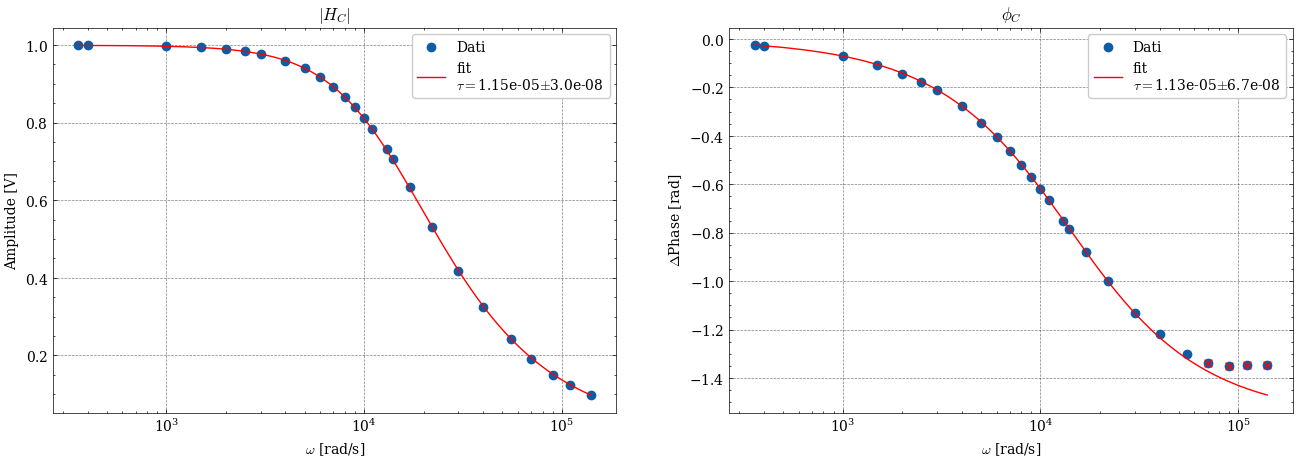

In [100]:
x = np.linspace(np.min(freqs[2:]),np.max(freqs[2:]),1000)

plt.subplots(1,2,figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(freqs[2:], V_c[2:], lw=1, label='Dati')
plt.plot(x, H_C(x*2*np.pi, f_m.values['tau'], f_m.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_m.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_m.errors["tau"])}', color='red')
plt.title("$|H_C|$")
plt.xscale('log')
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel('Amplitude [V]')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(freqs[2:], -fase_c[2:], lw=1, label='Dati')
plt.plot(x, fase_C(x*2*np.pi, f_f.values['tau'], f_f.values['a']), label='fit\n'+r'$\tau = $'f'{"{:.2e}".format(f_f.values["tau"])}''$\pm$'f'{"{:.1e}".format(f_f.errors["tau"])}', color='red')
plt.scatter(freqs[-4:], -fase_c[-4:], marker='x', s=30, c='r')
plt.title("$\phi_C$")
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel('$\Delta$Phase [rad]')
plt.xscale('log')
plt.legend()

plt.savefig('imgs/RC/fit_C.pdf', bbox_inches='tight', dpi=200)